In [4]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path='/content/drive/MyDrive/CVPR FACE'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pickle
import numpy as np
import cv2
import pandas as pd
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array


Found 237 images belonging to 3 classes.
Found 59 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 91s 11s/step - accuracy: 0.4543 - loss: 1.6135 - val_accuracy: 0.4576 - val_loss: 0.9226
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.7606 - loss: 0.7538 - val_accuracy: 0.8475 - val_loss: 0.4637
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9946 - loss: 0.1553 - val_accuracy: 0.8644 - val_loss: 0.3470
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 1.0000 - loss: 0.0290 - val_accuracy: 0.8814 - val_loss: 0.2859
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.9764 - loss: 0.0415 - val_accuracy: 0.8475 - val_loss: 2.1858
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.8644 - val_loss: 1.5730
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9991 - loss: 0.0101 - val_accuracy: 0.8644 - val_loss: 2.1381
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.8475 - val_loss: 1.4716
Epoch 9

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8575 - loss: 2.5753
Validation Accuracy: 86.44%


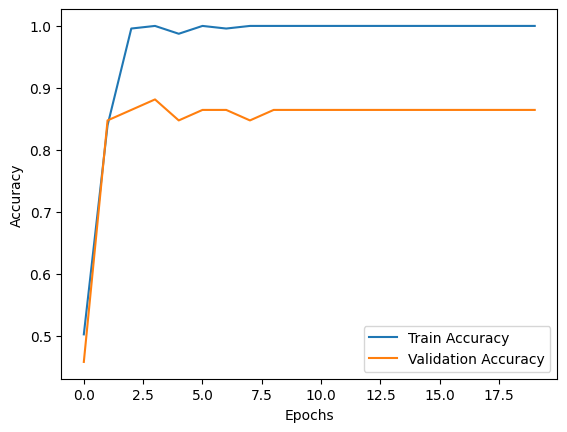

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define dataset path
dataset_path = "/content/drive/MyDrive/CVPR FACE"  # Change this to your actual dataset path

# Image settings
img_size = (128, 128)
batch_size = 32

# Data Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

# Build CNN Model
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes
])

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
epochs = 20
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

# Save Model
model.save("face_recognition_model.h5")

# Evaluate Model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Plot Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [6]:
class_names = ['AVISHEK', 'LAMYEA', 'SAGOR']

In [7]:
from tensorflow.keras import models, layers, applications, optimizers

# Load a pre-trained model (e.g., MobileNetV2) without the top classification layer
base_model = applications.MobileNetV2(
    input_shape=(256, 256, 3),  # Input shape for your images
    include_top=False,          # Exclude the top classification layer
    weights='imagenet'          # Load weights pre-trained on ImageNet
)

# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

# Create the transfer learning model
model = models.Sequential([
    # Pre-trained base model
    base_model,

    # Add custom layers for face recognition
    layers.GlobalAveragePooling2D(),  # Global average pooling to reduce dimensions
    layers.Dense(128, activation='relu'),  # Dense layer for feature extraction
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(4, activation='softmax')  # Output layer for 4 classes
])

# Unfreeze the top layers of the base model
base_model.trainable = True

# Fine-tune only the last few layers of the base model
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the updated model summary
model.summary()

<ipython-input-7-d0a058003db7>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 896,964 (3.42 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for validation data (ensure it's the same preprocessing as training)
val_datagen = ImageDataGenerator(rescale=1./255)  # Rescaling pixel values to [0, 1]

# Define the directory where your validation images are stored
val_dir = '/content/drive/MyDrive/CVPR FACE'  # Replace with the actual directory path

# Load the validation data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),  # Resize to the same input size as the model
    batch_size=32,
    class_mode='categorical'  # or 'binary' depending on your task
)

# Use the validation data generator for predictions
predictions = model.predict(val_generator, steps=val_generator.samples // val_generator.batch_size)


Found 296 images belonging to 3 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step


Found 360 images belonging to 3 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step
Predicted classes (first 10): [3 3 3 3 3 3 3 3 3 3]
Class names: {0: 'AVISHEK', 1: 'LAMYEA', 2: 'SAGOR'}


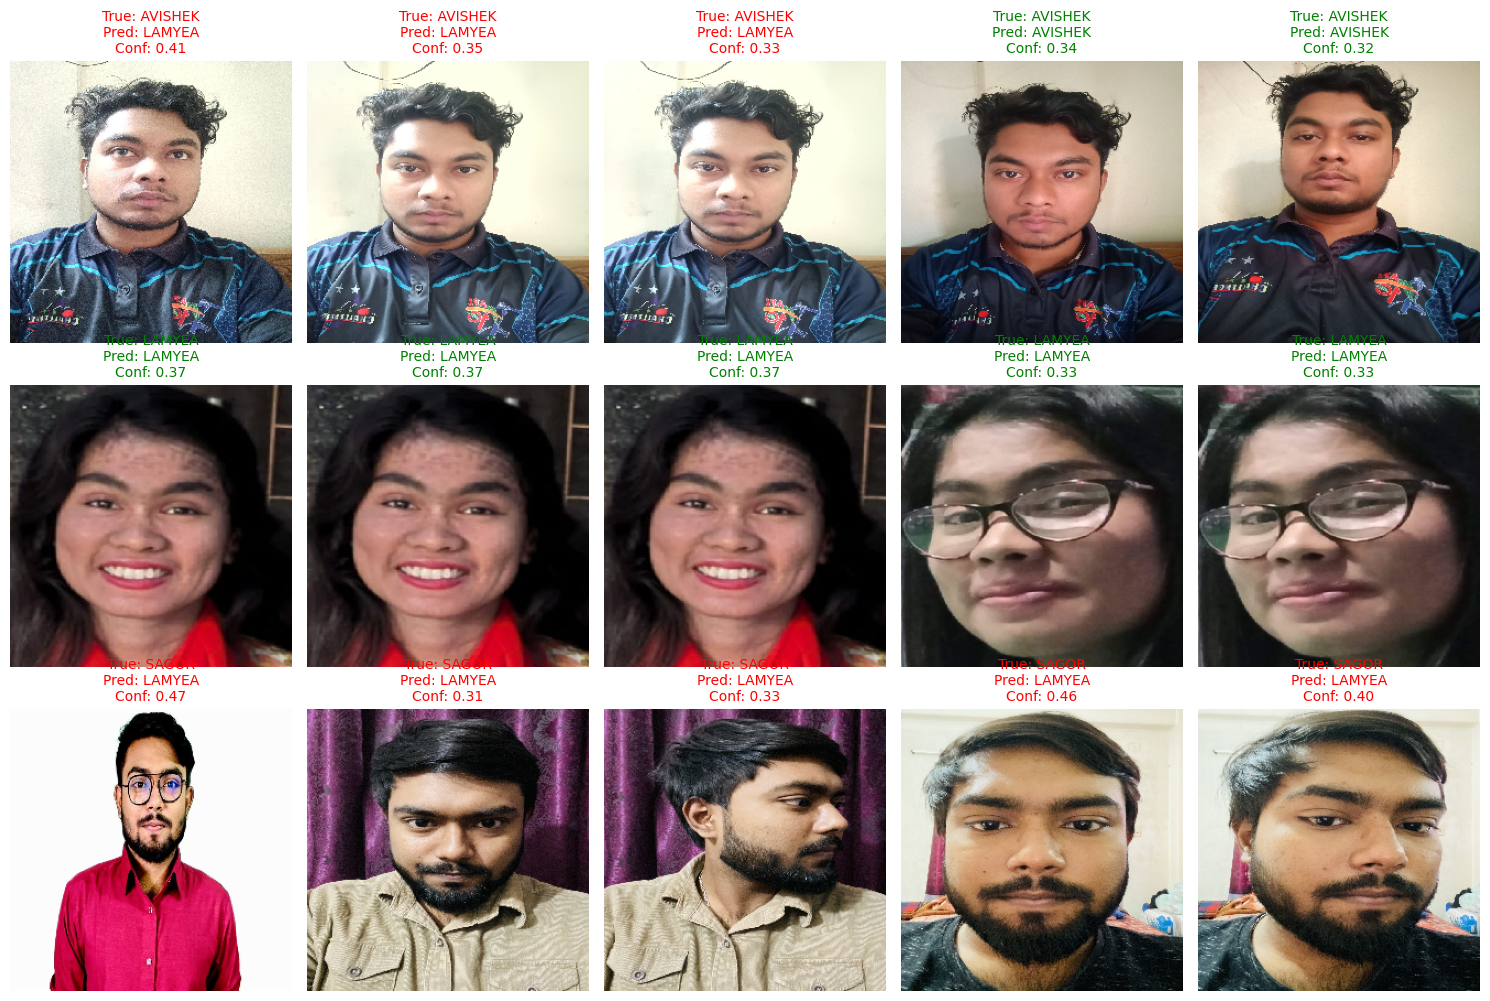

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for validation data
val_datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values

# Define the directory where validation images are stored
val_dir = '/content/drive/MyDrive/CVPR FACE'

# Load validation data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),  # Ensure images match the model input size
    batch_size=32,
    class_mode='categorical',  # or 'binary' depending on classification type
    shuffle=False  # Ensure labels match images in order
)

# Convert steps to integer to avoid errors
steps = int(np.ceil(val_generator.samples / val_generator.batch_size))

# Get predictions
predictions = model.predict(val_generator, steps=steps)

# Extract predicted classes and confidence levels
predicted_classes = np.argmax(predictions, axis=1)
confidence_levels = np.max(predictions, axis=1)

# Get true labels
val_labels = val_generator.classes  # True labels

# Get class names
class_names = {v: k for k, v in val_generator.class_indices.items()}  # Reverse mapping

# Print predicted classes for debugging
print(f"Predicted classes (first 10): {predicted_classes[:10]}")
print(f"Class names: {class_names}")

# Create a plot for 3 people, ensuring each appears
fig, axes = plt.subplots(3, 5, figsize=(15, 10))  # 3 rows for 3 people, 5 images each
axes = axes.ravel()

# Collect images per class
num_images_per_class = 5  # Show 5 images per person
images_per_class = {class_idx: 0 for class_idx in class_names.keys()}  # Track class count

idx = 0  # Image counter
batch_index = 0  # Track batch index

while any(images_per_class[c] < num_images_per_class for c in images_per_class) and batch_index < len(val_generator):
    images, labels = next(val_generator)  # Get a batch of images
    true_labels_batch = np.argmax(labels, axis=1)  # Convert one-hot to class indices

    # Ensure predictions match the current batch size
    start_idx = batch_index * val_generator.batch_size
    end_idx = min(start_idx + len(images), len(predicted_classes))  # To avoid index overflow

    for i in range(len(images)):
        true_label = true_labels_batch[i]

        # Only display if we haven't reached the required images per class
        if images_per_class[true_label] < num_images_per_class:
            # Show image
            axes[idx].imshow(images[i])
            axes[idx].axis('off')

            # Check if the predicted class index is within valid range
            predicted_class_idx = predicted_classes[start_idx + i]
            if predicted_class_idx not in class_names:
                print(f"Warning: Invalid predicted class index {predicted_class_idx} for image {idx}")
                continue  # Skip this image if the class index is invalid

            # Get prediction details
            predicted_label = class_names[predicted_class_idx]
            true_label_name = class_names[true_label]
            confidence = confidence_levels[start_idx + i]  # Adjusted to match the prediction index

            # Set title color (green if correct, red if incorrect)
            color = "green" if predicted_class_idx == true_label else "red"
            axes[idx].set_title(f"True: {true_label_name}\nPred: {predicted_label}\nConf: {confidence:.2f}",
                                color=color, fontsize=10)

            # Update counters
            images_per_class[true_label] += 1
            idx += 1

            # Stop once all 3 people have enough images
            if idx >= 15:
                break

    batch_index += 1  # Move to next batch

plt.tight_layout()
plt.show()



In [12]:
model.save('face_recognition_model.keras')

In [21]:
with open('class_labels.pkl', 'wb') as file:
    pickle.dump(class_names, file)

In [22]:
correct_labels = {0: "AVISHEK", 1: "SAGOR", 2: "LAMYEA"}  # Update based on training data
with open('/content/drive/MyDrive/categories.pkl', 'wb') as f:
    pickle.dump(correct_labels, f)


Class labels: {0: 'AVISHEK', 1: 'SAGOR', 2: 'LAMYEA'}


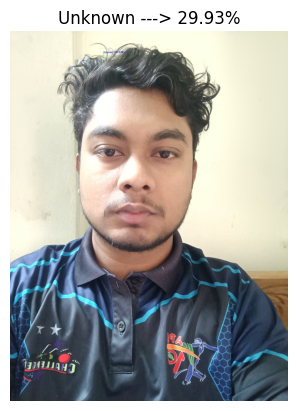

In [25]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pickle

# Load the saved model
model = load_model('/content/face_recognition_model.keras')

# Load the label encoder or class labels
with open('/content/drive/MyDrive/categories.pkl', 'rb') as f:
    class_labels = pickle.load(f)

# Ensure class_labels is a list and contains the correct labels
print(f"Class labels: {class_labels}")

# Haar cascade path for face detection
haarcascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(haarcascade_path)

# Function to preprocess the face
def preprocess_face(face, target_shape):
    normalized_face = cv2.resize(face, (target_shape[1], target_shape[2])) / 255.0
    face_array = np.expand_dims(normalized_face, axis=0)
    return face_array

# Function to recognize and display the result
def recognize_image_with_haarcascade(image_path, confidence_threshold=0.5):
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image from {image_path}")
        return

    # Convert the image to grayscale for Haar cascade
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No face detected.")
        return

    # Process the first detected face
    x, y, w, h = faces[0]
    face = img[y:y+h, x:x+w]  # Crop the detected face

    # Preprocess the face
    face_array = preprocess_face(face, model.input_shape)

    # Predict the label
    predictions = model.predict(face_array, verbose=0)
    confidence = np.max(predictions)
    label_index = np.argmax(predictions)

    # Ensure the label index is valid before fetching the label
    label = class_labels[label_index] if label_index < len(class_labels) and confidence >= confidence_threshold else "Unknown"

    # Display the result
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(
        img,
        f"{label} ({confidence*100:.2f}%)",
        (x, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (255, 0, 0),
        2,
    )

    # Display the image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"{label} ---> {confidence*100:.2f}%")
    plt.show()

# Path to the image you want to recognize
image_path = '/content/drive/MyDrive/CVPR FACE/AVISHEK/IMG_20241207_120759.jpg'  # Update this to your image path

# Recognize the image using Haar cascade
recognize_image_with_haarcascade(image_path, confidence_threshold=0.85)
